In [6]:
import cv2
import numpy as np

## Setting up camera

In [ ]:
# def nothing(x):
#     pass

# cv2.namedWindow("Window")
# cv2.createTrackbar("Param Name", "Window", 0, 10, nothing)

In [7]:
def try_camera(func):
    cap = cv2.VideoCapture(0)

    while(True):
        # Capture frame-by-frame
        ret, frame = cap.read()

        # Our operations on the frame come here
        try:
            gray = func(frame) # cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Display the resulting frame
            cv2.imshow('frame', gray)
        except:
            print("Nothing found...")
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()
    
# try_camera(lambda x : x)

## Part 1: Extracting Hand from Feed

In [8]:
# ! {"pip install matplotlib"}

In [9]:
frame = np.load('open_palm.npy')

In [10]:
import matplotlib.pyplot as plt

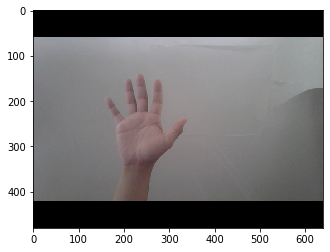

In [11]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [12]:
frame.shape

(480, 640, 3)

In [13]:
def get_skinmask(frame):
    lower_HSV = np.array([0, 70, 0], dtype = "uint8")  
    upper_HSV = np.array([25, 255, 255], dtype = "uint8")  

    convertedHSV = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)  
    skinMaskHSV = cv2.inRange(convertedHSV, lower_HSV, upper_HSV)  


    lower_YCrCb = np.array((0, 138, 67), dtype = "uint8")  
    upper_YCrCb = np.array((255, 173, 133), dtype = "uint8")  

    convertedYCrCb = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)  
    skinMaskYCrCb = cv2.inRange(convertedYCrCb, lower_YCrCb, upper_YCrCb)  

    skinMask = cv2.add(skinMaskHSV,skinMaskYCrCb)  
    return skinMask

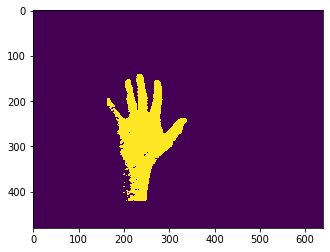

In [14]:
plt.imshow(get_skinmask(frame))

Testing Code

In [9]:
try_camera(get_skinmask)

KeyboardInterrupt: 

In [15]:
def morph_and_blur(frame, skinMask):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))  
    skinMask = cv2.erode(skinMask, kernel, iterations = 1)  
    skinMask = cv2.dilate(skinMask, kernel, iterations = 1)  

    # blur the mask to help remove noise, then apply the  
    # mask to the frame  
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0) 
    skin = cv2.bitwise_and(frame, frame, mask = skinMask) 
    return skin

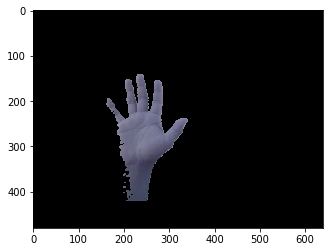

In [16]:
plt.imshow(morph_and_blur(frame, get_skinmask(frame)))

In [17]:
isolate = lambda x : morph_and_blur(x, get_skinmask(x))
try_camera(isolate)

KeyboardInterrupt: 

## Part 2: Connected Components for Gesture Recognition

In [18]:
ok_hand = np.load('ok.npy')

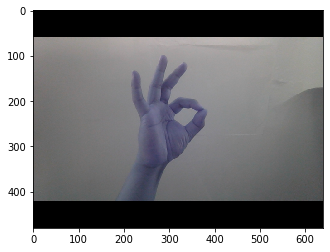

In [19]:
plt.imshow(ok_hand)

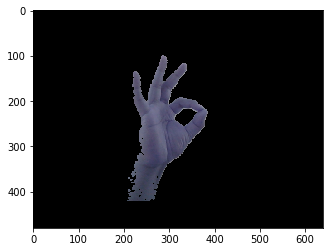

In [20]:
plt.imshow(isolate(ok_hand).astype(np.uint8))

In [21]:
def gray_thresh(frame):
    max_binary_value = 10
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)  
    ret, thresh = cv2.threshold(gray, 0, max_binary_value, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU )
    return thresh # thresh if ret else None

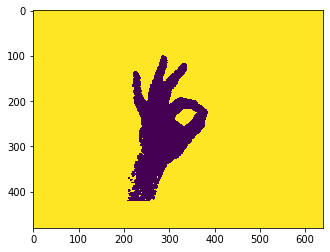

In [22]:
plt.imshow(gray_thresh(isolate(ok_hand)))

In [23]:
def arr2img(arr):
    arr = np.uint8(arr / np.max(arr) * 255)
    return cv2.merge([arr, arr, arr])

In [24]:
# try_camera(lambda x : arr2img(gray_thresh(isolate(x))))

In [25]:
def get_connect(img):
    ret, markers, stats, centroids = cv2.connectedComponentsWithStats(img, ltype=cv2.CV_16U)  
    markers = np.array(markers, dtype=np.uint8)  
    return arr2img(markers)

In [26]:
marks = get_connect(gray_thresh(isolate(ok_hand)))

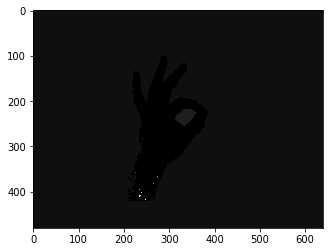

In [27]:
plt.imshow(marks)

Test out code so far...

In [28]:
render_comps = lambda x : get_connect(gray_thresh(isolate(x)))
# try_camera(render_comps)

In [29]:
def get_connect2(img):
    ret, markers, stats, centroids = cv2.connectedComponentsWithStats(img, ltype=cv2.CV_16U)  
    markers = np.array(markers, dtype=np.uint8)  
    labeled_img = arr2img(markers)
    
    # sort by area of ROI
    statsSortedByArea = stats[np.argsort(stats[:, 4])]  
    roi = statsSortedByArea[-3][0:4]  
    x, y, w, h = roi  
    subImg = labeled_img[y:y+h, x:x+w]
    subImg = cv2.cvtColor(subImg, cv2.COLOR_BGR2GRAY)
    
    _, contours, _ = cv2.findContours(subImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  
    maxCntLength = 0  
    for i in range(0,len(contours)):  
        cntLength = len(contours[i])  
        if(cntLength>maxCntLength):  
            cnt = contours[i]  
            maxCntLength = cntLength  
    if(maxCntLength>=5):  
        ellipseParam = cv2.fitEllipse(cnt)
        (x,y), (MA, ma), angle = ellipseParam
        print(f"(x={x}, y={y}), (MA={MA}, ma={ma}), Angle={angle}")
        subImg = cv2.cvtColor(subImg, cv2.COLOR_GRAY2RGB);  
        subImg = cv2.ellipse(subImg,ellipseParam,(0,255,0),2)  

    subImg = cv2.resize(subImg, (0,0), fx=3, fy=3)
    return subImg

In [30]:
render_comps2 = lambda x : get_connect2(gray_thresh(isolate(x)))
try_camera(render_comps2)

(x=5.473849773406982, y=4.940258026123047), (MA=8.60167121887207, ma=11.021085739135742), Angle=115.54621124267578
(x=1.929065227508545, y=3.646636486053467), (MA=5.104234218597412, ma=6.762219429016113), Angle=158.39723205566406
(x=4.541604518890381, y=1.7851238250732422), (MA=1.8144659996032715, ma=9.760565757751465), Angle=107.11420440673828
(x=4.525556564331055, y=1.6624972820281982), (MA=4.456130504608154, ma=10.597375869750977), Angle=78.73497772216797
(x=3.182874917984009, y=1.9621856212615967), (MA=3.7943100929260254, ma=7.193973541259766), Angle=103.6662368774414
(x=5.384770393371582, y=5.091358661651611), (MA=9.617775917053223, ma=12.148307800292969), Angle=99.45317077636719
(x=3.9353761672973633, y=5.555030822753906), (MA=7.443967819213867, ma=12.603687286376953), Angle=49.23193359375
(x=3.479097366333008, y=4.8986124992370605), (MA=7.996179103851318, ma=10.79564094543457), Angle=169.02146911621094
(x=2.2522330284118652, y=6.072267532348633), (MA=5.668233394622803, ma=11.591

(x=4.5518670082092285, y=1.4861855506896973), (MA=2.2023587226867676, ma=10.31313705444336), Angle=102.93092346191406
(x=2.97217059135437, y=0.2589675784111023), (MA=4.307026386260986, ma=6.1887898445129395), Angle=87.43902587890625
(x=10.642999649047852, y=-1.0262792110443115), (MA=7.182136535644531, ma=15.23568058013916), Angle=0.0
(x=4.510037422180176, y=3.9855213165283203), (MA=5.738444805145264, ma=11.590238571166992), Angle=123.54325103759766
(x=5.027599811553955, y=2.794914960861206), (MA=5.923353672027588, ma=10.27065658569336), Angle=89.83781433105469
(x=5.982051849365234, y=2.549283504486084), (MA=5.164670467376709, ma=12.712421417236328), Angle=100.8493423461914
(x=3.079331874847412, y=1.746996283531189), (MA=4.406248092651367, ma=6.1565632820129395), Angle=113.49992370605469
(x=1.606469750404358, y=4.414642810821533), (MA=3.167017698287964, ma=9.291206359863281), Angle=5.204394817352295
(x=5.932130813598633, y=2.0463685989379883), (MA=3.81238055229187, ma=12.27782154083252)

(x=6.534826755523682, y=2.553224563598633), (MA=5.3968915939331055, ma=13.489340782165527), Angle=96.82919311523438
(x=2.7504570484161377, y=4.458597183227539), (MA=4.682640075683594, ma=11.791275024414062), Angle=23.488805770874023
(x=2.986433982849121, y=5.307992935180664), (MA=5.180083274841309, ma=10.487659454345703), Angle=16.650409698486328
(x=2.322078227996826, y=4.729879379272461), (MA=3.706641674041748, ma=8.778247833251953), Angle=158.87615966796875
(x=9.41670036315918, y=2.1615335941314697), (MA=3.6394875049591064, ma=16.370784759521484), Angle=94.29427337646484
(x=7.780534267425537, y=1.6015852689743042), (MA=3.078274726867676, ma=16.045974731445312), Angle=88.81141662597656
(x=7.260295867919922, y=3.3301689624786377), (MA=5.989274501800537, ma=14.444550514221191), Angle=105.42012023925781
(x=1.9505422115325928, y=4.932380676269531), (MA=3.5559494495391846, ma=9.154132843017578), Angle=7.665109634399414
(x=4.041032314300537, y=3.7799718379974365), (MA=4.018587112426758, ma=

(x=5.596257209777832, y=3.569201946258545), (MA=5.375492572784424, ma=12.253273010253906), Angle=116.59723663330078
(x=2.799999952316284, y=0.5), (MA=0.0, ma=1.0), Angle=0.0
(x=3.4592173099517822, y=2.3665218353271484), (MA=3.5168025493621826, ma=7.384160041809082), Angle=115.3519058227539
(x=9.005331039428711, y=3.9969325065612793), (MA=6.545131683349609, ma=15.937227249145508), Angle=113.33943176269531
(x=2.4840645790100098, y=-1.9971702098846436), (MA=7.3176655769348145, ma=19.870779037475586), Angle=115.89199829101562
(x=4.614015102386475, y=6.699769973754883), (MA=6.689777374267578, ma=13.101358413696289), Angle=22.706754684448242
(x=6.217191219329834, y=4.838942527770996), (MA=9.072237014770508, ma=10.981712341308594), Angle=99.4388427734375
(x=6.2885026931762695, y=3.120966911315918), (MA=5.9231767654418945, ma=11.799920082092285), Angle=88.08768463134766
(x=6.272126197814941, y=3.2200334072113037), (MA=5.864858627319336, ma=13.039458274841309), Angle=71.72649383544922
(x=6.3321

(x=3.6041324138641357, y=5.710511684417725), (MA=4.06586217880249, ma=13.77824592590332), Angle=139.69534301757812
(x=1.223949909210205, y=0.9817823171615601), (MA=1.9687010049819946, ma=3.3113644123077393), Angle=111.0063247680664
(x=1.1201953887939453, y=1.6759341955184937), (MA=2.2582387924194336, ma=3.235093116760254), Angle=154.28819274902344
(x=2.621194362640381, y=3.059352159500122), (MA=5.616408348083496, ma=6.866382122039795), Angle=95.83641052246094
(x=4.041136741638184, y=3.3057520389556885), (MA=4.271711349487305, ma=8.593053817749023), Angle=51.644107818603516
(x=1.9803426265716553, y=1.8519399166107178), (MA=3.5912771224975586, ma=5.086333274841309), Angle=32.6440315246582
(x=3.057767629623413, y=8.025137901306152), (MA=5.137643814086914, ma=13.752015113830566), Angle=175.70751953125
(x=5.16776180267334, y=8.038535118103027), (MA=8.22398853302002, ma=15.572090148925781), Angle=29.421823501586914
(x=0.939666211605072, y=2.797182559967041), (MA=2.31931734085083, ma=5.958379

(x=55.3524284362793, y=36.4481201171875), (MA=58.998146057128906, ma=115.92338562011719), Angle=109.81007385253906
(x=54.833866119384766, y=39.78285598754883), (MA=63.8473014831543, ma=114.60136413574219), Angle=108.14208984375
(x=11.491189956665039, y=11.572768211364746), (MA=17.509851455688477, ma=26.887346267700195), Angle=41.725093841552734
(x=73.58253479003906, y=58.11674499511719), (MA=98.4090576171875, ma=128.56716918945312), Angle=107.76428985595703
(x=20.479496002197266, y=14.492400169372559), (MA=23.922710418701172, ma=38.740936279296875), Angle=74.69801330566406
(x=20.46082305908203, y=10.27147388458252), (MA=19.287918090820312, ma=33.76059341430664), Angle=88.5450439453125
(x=11.025625228881836, y=10.453364372253418), (MA=18.059412002563477, ma=24.096891403198242), Angle=45.86188888549805
(x=14.184293746948242, y=10.981549263000488), (MA=24.741365432739258, ma=28.978717803955078), Angle=86.77629089355469
(x=13.615750312805176, y=12.966769218444824), (MA=18.498559951782227, 

(x=18.998794555664062, y=13.287752151489258), (MA=30.86992835998535, ma=34.179649353027344), Angle=148.13946533203125
(x=1.1217930316925049, y=3.4420816898345947), (MA=3.2631113529205322, ma=7.156803131103516), Angle=28.082780838012695
(x=11.540728569030762, y=12.725179672241211), (MA=19.286466598510742, ma=27.709945678710938), Angle=38.8768424987793
(x=14.104790687561035, y=14.011167526245117), (MA=23.27480125427246, ma=31.176679611206055), Angle=114.59687042236328
(x=14.890763282775879, y=14.432266235351562), (MA=25.099985122680664, ma=34.14988327026367), Angle=84.3191909790039
(x=13.608357429504395, y=9.740730285644531), (MA=18.182403564453125, ma=26.76968765258789), Angle=78.59672546386719
(x=14.168689727783203, y=10.63572883605957), (MA=21.955211639404297, ma=23.989055633544922), Angle=103.3857650756836
(x=20.624929428100586, y=9.706070899963379), (MA=17.434110641479492, ma=33.926246643066406), Angle=90.2690658569336
(x=9.048737525939941, y=5.487079620361328), (MA=10.7453908920288

(x=1.9381132125854492, y=1.953157663345337), (MA=2.6926493644714355, ma=5.198673725128174), Angle=48.933197021484375
(x=2.2150826454162598, y=4.476789951324463), (MA=2.4867091178894043, ma=9.580140113830566), Angle=158.4591064453125
(x=6.107738971710205, y=2.6600537300109863), (MA=4.407045364379883, ma=13.46269416809082), Angle=101.8475112915039
(x=4.803950309753418, y=1.2472141981124878), (MA=6.688080787658691, ma=10.4246826171875), Angle=129.30062866210938
(x=3.839437484741211, y=4.6545610427856445), (MA=5.933459281921387, ma=11.549564361572266), Angle=37.22850036621094
(x=5.571375846862793, y=5.577022552490234), (MA=9.111239433288574, ma=12.525806427001953), Angle=68.69644927978516
(x=15.351475715637207, y=6.560264587402344), (MA=9.331494331359863, ma=34.07707214355469), Angle=73.5842056274414
(x=1.6864570379257202, y=2.313058853149414), (MA=3.3689894676208496, ma=11.02938461303711), Angle=118.19097137451172
(x=8.799086570739746, y=3.4662115573883057), (MA=5.235759258270264, ma=16.7

(x=3.129943370819092, y=3.4477686882019043), (MA=4.100876331329346, ma=9.58280086517334), Angle=29.28795623779297
(x=3.454634428024292, y=3.2419815063476562), (MA=6.888355255126953, ma=11.190759658813477), Angle=86.88954162597656
(x=7.43349552154541, y=6.0764641761779785), (MA=6.9459404945373535, ma=18.083284378051758), Angle=131.6237335205078
(x=6.011614799499512, y=-0.13617265224456787), (MA=2.786799669265747, ma=3.044973134994507), Angle=133.09408569335938
(x=9.549640655517578, y=7.731247901916504), (MA=12.732345581054688, ma=19.22358512878418), Angle=60.16796112060547
(x=2.404935598373413, y=2.671030282974243), (MA=4.667977333068848, ma=5.606709003448486), Angle=129.41868591308594
(x=3.671424388885498, y=1.7523795366287231), (MA=4.598669052124023, ma=7.115505695343018), Angle=104.50162506103516
(x=1.5380849838256836, y=1.408111810684204), (MA=2.659759283065796, ma=3.5495598316192627), Angle=123.7462387084961
(x=9.253617286682129, y=6.035008430480957), (MA=12.84595012664795, ma=17.9

(x=1.4614449739456177, y=2.9155068397521973), (MA=3.7889442443847656, ma=8.643854141235352), Angle=5.664212226867676
(x=5.598158836364746, y=2.0073187351226807), (MA=2.3844499588012695, ma=11.549559593200684), Angle=105.54236602783203
(x=5.482461452484131, y=2.4880833625793457), (MA=6.330120086669922, ma=10.864800453186035), Angle=140.71839904785156
(x=6.545957565307617, y=4.439332008361816), (MA=7.6897406578063965, ma=15.052338600158691), Angle=110.33979034423828
(x=15.899026870727539, y=5.411350727081299), (MA=10.008870124816895, ma=27.68674087524414), Angle=97.35284423828125
(x=22.560447692871094, y=14.290699005126953), (MA=26.369630813598633, ma=38.064823150634766), Angle=90.0767822265625
(x=3.570587635040283, y=3.1760945320129395), (MA=6.031832695007324, ma=9.20478343963623), Angle=83.59562683105469
(x=-1.234506607055664, y=-3.2707602977752686), (MA=9.15058708190918, ma=22.49036407470703), Angle=131.50425720214844
(x=8.52367877960205, y=6.868781566619873), (MA=10.176839828491211, 

(x=4.463367462158203, y=4.43398380279541), (MA=6.91965913772583, ma=14.473334312438965), Angle=99.31491088867188
(x=9.627138137817383, y=4.663097381591797), (MA=8.308280944824219, ma=20.69887351989746), Angle=80.56776428222656
(x=1.432087779045105, y=2.7120635509490967), (MA=2.895956516265869, ma=6.957265377044678), Angle=171.3686065673828
(x=2.5943808555603027, y=1.5904126167297363), (MA=2.8313891887664795, ma=5.676513195037842), Angle=65.76941680908203
(x=10.665508270263672, y=6.089675426483154), (MA=9.78393840789795, ma=25.3124942779541), Angle=75.74049377441406
(x=4.203192234039307, y=2.806697130203247), (MA=7.904545783996582, ma=9.969339370727539), Angle=90.11318969726562
(x=1.9120254516601562, y=3.7317183017730713), (MA=3.447852849960327, ma=8.35059928894043), Angle=161.896240234375
(x=5.2819929122924805, y=6.2661452293396), (MA=7.055399417877197, ma=13.282367706298828), Angle=140.74139404296875
(x=5.316540718078613, y=2.818341016769409), (MA=6.012971878051758, ma=10.650225639343

(x=51.0970458984375, y=33.32784652709961), (MA=52.43171691894531, ma=110.54137420654297), Angle=65.82061004638672
(x=51.7979621887207, y=31.361652374267578), (MA=52.68840026855469, ma=110.07305908203125), Angle=67.3573989868164
(x=49.61363220214844, y=45.50257873535156), (MA=84.82084655761719, ma=109.64653015136719), Angle=96.54173278808594
(x=52.82474136352539, y=32.54377365112305), (MA=55.22990417480469, ma=110.08145904541016), Angle=70.28794860839844
(x=52.439300537109375, y=34.27249526977539), (MA=53.547664642333984, ma=110.1375503540039), Angle=66.93319702148438
(x=51.58371353149414, y=47.475677490234375), (MA=71.92874145507812, ma=105.7237548828125), Angle=65.68891906738281
(x=50.81877899169922, y=35.06027603149414), (MA=53.57073974609375, ma=113.74496459960938), Angle=58.262821197509766
(x=52.78593444824219, y=33.59696960449219), (MA=55.725341796875, ma=111.20136260986328), Angle=61.54169845581055
(x=50.806705474853516, y=33.20844650268555), (MA=54.41676712036133, ma=109.0888442

(x=44.392303466796875, y=48.70155715942383), (MA=64.26473236083984, ma=98.18698120117188), Angle=42.950355529785156
(x=42.048194885253906, y=30.806962966918945), (MA=41.05392074584961, ma=89.77401733398438), Angle=59.20363235473633
(x=38.02172088623047, y=26.256643295288086), (MA=32.015869140625, ma=90.5046615600586), Angle=59.87283706665039
(x=43.3807373046875, y=33.815216064453125), (MA=44.480525970458984, ma=103.39839172363281), Angle=53.03831100463867
(x=31.447528839111328, y=38.2673454284668), (MA=35.44898986816406, ma=88.1303939819336), Angle=40.595401763916016
(x=37.15122985839844, y=33.27101135253906), (MA=39.46310806274414, ma=77.05433654785156), Angle=41.91571044921875
(x=27.18448829650879, y=27.086572647094727), (MA=31.285518646240234, ma=60.18489456176758), Angle=41.727928161621094
(x=10.007899284362793, y=6.614498615264893), (MA=11.60212230682373, ma=18.401565551757812), Angle=74.47224426269531
(x=3.509596347808838, y=6.010639190673828), (MA=6.983386039733887, ma=10.389600

(x=49.36418533325195, y=46.18973922729492), (MA=84.13914489746094, ma=94.80491638183594), Angle=103.89678192138672
(x=51.55957794189453, y=46.19511795043945), (MA=83.33628845214844, ma=97.35736846923828), Angle=95.1943359375
(x=51.34639358520508, y=42.77336883544922), (MA=79.03033447265625, ma=101.83341979980469), Angle=92.63734436035156
(x=54.292694091796875, y=39.56887435913086), (MA=68.61691284179688, ma=107.43898010253906), Angle=90.30453491210938
(x=56.39365005493164, y=34.108306884765625), (MA=61.97684097290039, ma=112.29237365722656), Angle=88.69599914550781
(x=53.29197692871094, y=30.241851806640625), (MA=55.956748962402344, ma=113.21324920654297), Angle=87.19522094726562
(x=52.46586608886719, y=25.928768157958984), (MA=48.12158203125, ma=112.02857971191406), Angle=86.78680419921875
(x=49.9169921875, y=22.193565368652344), (MA=45.59871292114258, ma=106.8442611694336), Angle=85.12577819824219
(x=49.27980041503906, y=22.37565040588379), (MA=43.80723571777344, ma=107.1325988769531

(x=45.533809661865234, y=39.55939865112305), (MA=64.75507354736328, ma=88.71208953857422), Angle=90.32768249511719
(x=44.33244323730469, y=35.30226516723633), (MA=59.66061782836914, ma=87.4117660522461), Angle=91.50374603271484
(x=44.94145202636719, y=35.05403518676758), (MA=61.51694869995117, ma=87.19871520996094), Angle=92.44439697265625
(x=46.93767547607422, y=43.26240158081055), (MA=73.23297882080078, ma=96.0932846069336), Angle=77.45010375976562
(x=52.56999588012695, y=47.81200408935547), (MA=83.33145904541016, ma=96.1208267211914), Angle=97.85797882080078
(x=40.581573486328125, y=9.01239013671875), (MA=13.877836227416992, ma=71.56305694580078), Angle=85.24903106689453
(x=4.309441089630127, y=4.344405651092529), (MA=3.5753817558288574, ma=11.189691543579102), Angle=50.2623291015625
(x=3.0317330360412598, y=2.4982244968414307), (MA=4.228011608123779, ma=6.7673139572143555), Angle=54.9859504699707
(x=-2.0, y=0.0), (MA=5.416118621826172, ma=9.641173362731934), Angle=173.4442443847656

(x=1.4621692895889282, y=1.615636944770813), (MA=2.94065260887146, ma=3.3614633083343506), Angle=132.26434326171875
(x=2.287193775177002, y=3.5371456146240234), (MA=4.254239559173584, ma=7.610520839691162), Angle=154.75946044921875
(x=3.0999999046325684, y=0.699999988079071), (MA=1.3155806064605713, ma=3.8467414379119873), Angle=0.0
(x=4.358771324157715, y=4.544013500213623), (MA=3.510746955871582, ma=11.595805168151855), Angle=142.01747131347656
(x=2.4037601947784424, y=5.951709747314453), (MA=5.363928318023682, ma=10.789758682250977), Angle=176.41278076171875
(x=3.796783924102783, y=2.345738649368286), (MA=5.244173049926758, ma=10.102788925170898), Angle=73.46800994873047
(x=7.191878318786621, y=4.030351161956787), (MA=9.32394790649414, ma=14.054104804992676), Angle=112.40802001953125
(x=2.783918857574463, y=2.4957520961761475), (MA=4.168509006500244, ma=6.7901740074157715), Angle=32.15288543701172
(x=3.1657967567443848, y=2.3089935779571533), (MA=4.691624164581299, ma=6.639059543609

(x=4.0, y=0.5), (MA=0.0, ma=1.0), Angle=0.0
(x=3.41033673286438, y=2.2655627727508545), (MA=4.6117143630981445, ma=7.480146884918213), Angle=60.65658187866211
(x=6.561393737792969, y=3.877479076385498), (MA=6.000101566314697, ma=13.641105651855469), Angle=105.83965301513672
(x=7.819989204406738, y=6.032711029052734), (MA=8.517583847045898, ma=16.264162063598633), Angle=122.64616394042969
(x=5.738406181335449, y=3.2339441776275635), (MA=6.864895343780518, ma=11.386667251586914), Angle=97.71943664550781
(x=3.289156675338745, y=1.2650601863861084), (MA=5.204528331756592, ma=8.068123817443848), Angle=82.98188018798828
(x=6.354264259338379, y=4.507196426391602), (MA=7.699158191680908, ma=12.662079811096191), Angle=109.28441619873047
(x=3.6941447257995605, y=1.3021910190582275), (MA=3.508697271347046, ma=7.125991344451904), Angle=100.11494445800781
(x=4.8776679039001465, y=-0.7027263641357422), (MA=7.014004230499268, ma=20.98582649230957), Angle=22.303678512573242
(x=2.07456111907959, y=1.44

KeyboardInterrupt: 

## Part 3: Tracking 2D Finger Positions

In [31]:
def get_gray_thresh(x):
    img = arr2img(1 * (gray_thresh(isolate(x)) == 0))
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

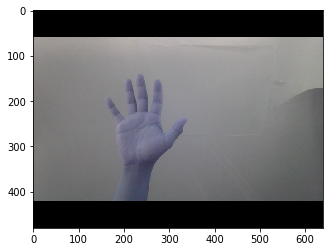

In [32]:
plt.imshow(np.load('open_palm.npy'))

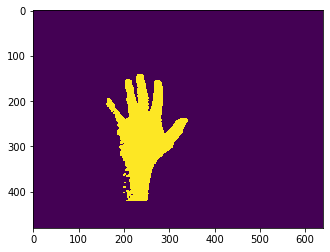

In [33]:
plt.imshow(get_gray_thresh(np.load('open_palm.npy')))

In [34]:
def get_hull(thresholdedHandImage):
    _, contours, _ = cv2.findContours(thresholdedHandImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    thresholdedHandImage = cv2.cvtColor(thresholdedHandImage, cv2.COLOR_GRAY2BGR)
    contours = sorted(contours,key=cv2.contourArea,reverse=True)
    fingerCount = 0
    fingerPts = []
    if len(contours)>1:  
        largestContour = contours[0]  
        hull = cv2.convexHull(largestContour, returnPoints = False)     
        for cnt in contours[:1]:  
            defects = cv2.convexityDefects(cnt,hull)  
            if(not isinstance(defects,type(None))):  
                for i in range(defects.shape[0]):  
                    s,e,f,d = defects[i,0]  
                    start = tuple(cnt[s][0])  
                    end = tuple(cnt[e][0])  
                    far = tuple(cnt[f][0])
                    
                    # finger detection
                    c_squared = (end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2  
                    a_squared = (far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2  
                    b_squared = (end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2  
                    angle = np.arccos((a_squared + b_squared  - c_squared ) / (2 * np.sqrt(a_squared * b_squared ))) 
                    
                    if angle <= np.pi / 3:
                        fingerCount += 1 
                        cv2.circle(thresholdedHandImage,far,5,[0,0,255],-1)
                        fingerPts.append(far)
                    cv2.line(thresholdedHandImage,start,end,[0,255,0],2)
                
        print(fingerCount)
        
    return thresholdedHandImage

In [35]:
get_conv_img = lambda x : get_hull(get_gray_thresh(x))

3


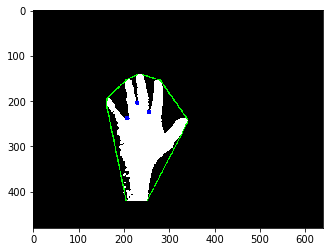

In [36]:
plt.imshow(get_conv_img(np.load('open_palm.npy')))

In [37]:
try_camera(get_conv_img)

0
0
0
1
1
3
1
0
2
1
1
1
2
4
0
0
0
2
4
4
4
5
4
4
4
4
5
5
6
5
5
5
4
4
5
5
5
4
6
5
4
4
6
4
1
3
1
2
2
1
1
2
3
1
2
4
4
4
4
4
6
4
4
4
4
3
3
5
4
5
5
5
5
5
4
4
5
4
3
4
4
4
4
3
4
5
4
3
3
3
4
4
3
5
4
3
4
4
3
4
4
4
4
5
4
4
4
3
4
4
6
3
3
4
5
6
4
5
4
4
3
3
4
3
3
3
3
4
4
4
4
4
4
1
1
0
2
0
1
4
4
6
5
7
4
1
2
2
2
1
1
1
1
3
2
2
2
3
2
2
3
2
3
4
2
0
0
0
0
1
2
4
3
2
3
4
3
1
1
0
3
3
1
1
1
3


KeyboardInterrupt: 

## Part 4: Control Mouse and Keyboard

Simple Gestures:
1. Finger Count:
    - 2 = open file
    - 3 = save file
2. OK Sign / Pinch:
    - Click

Complex Gestures:

3. Open - Close -> Close - Open
    - Next Song / Prev Song
4. Rotation of the Pinch 
5. Size of the Pinch
6. Move of Hand 
    - Move of the cursor

In [38]:
from scipy.stats import mode

In [63]:
def paint_conv_on_frame(thresholdedHandImage, regular_img, centers, open_closes, finger_counts, cdists):
    _, contours, _ = cv2.findContours(thresholdedHandImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText  = (10,30)
    bottomLeftCornerOfText2 = (10,60)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2
    
    thresholdedHandImage = regular_img
    contours = sorted(contours,key=cv2.contourArea,reverse=True)
    fingerCount = 0
    fingerPts = []
    startEndPts = []
    if len(contours)>1:  
        largestContour = contours[0]  
        hull = cv2.convexHull(largestContour, returnPoints = False)     
        for cnt in contours[:1]:  
            defects = cv2.convexityDefects(cnt,hull)  
            if(not isinstance(defects,type(None))):  
                for i in range(defects.shape[0]):  
                    s,e,f,d = defects[i,0]  
                    start = tuple(cnt[s][0])  
                    end = tuple(cnt[e][0])  
                    far = tuple(cnt[f][0])
                    
                    # finger detection
                    c_squared = (end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2  
                    a_squared = (far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2  
                    b_squared = (end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2  
                    angle = np.arccos((a_squared + b_squared  - c_squared ) / (2 * np.sqrt(a_squared * b_squared ))) 
                    
                    if angle <= np.pi / 3:
                        fingerCount += 1 
                        cv2.circle(thresholdedHandImage,far,5,[0,0,255],-1)
                        fingerPts.append([far[i] for i in range(len(far))])
                    
                    cv2.line(thresholdedHandImage,start,end,[0,255,0],2)
                    startEndPts.append([start[i] for i in range(len(start))])   
                    
        # Hand Tracking
        if len(startEndPts) > 5:
            M = cv2.moments(largestContour)  
            cX = 0 + 1 * int(M["m10"] / M["m00"])  
            cY = 0 + int(0.9 * M["m01"] / M["m00"])
            centers.append(np.array([cX, cY]))
            centers_mat = np.vstack(centers)
            center = np.mean(centers_mat, axis=0).astype(np.int)

            font                   = cv2.FONT_HERSHEY_SIMPLEX
            bottomLeftCornerOfText = (10,30)
            fontScale              = 1
            fontColor              = (255,255,255)
            lineType               = 2
            cv2.circle(thresholdedHandImage, (center[0], center[1]), 5, [0,255,255], -1)
        
        # Draw Circle from Moment Center
        if len(startEndPts) > 5:
            pts = np.array(startEndPts)
            min_pts = np.array([cX, np.amin(pts, axis=0)[1]])
            dist = np.linalg.norm(min_pts - center, 2)
            thresholdedHandImage = cv2.circle(
                thresholdedHandImage, (center[0], center[1]), 60, [0,255,255], 2)
            thresholdedHandImage = cv2.circle(
                thresholdedHandImage, (center[0], center[1]), 120, [0,255,255], 2)
            thresholdedHandImage = cv2.circle(
                thresholdedHandImage, (center[0], center[1]), int(dist), [0,255,0], 2)
            cdists.append(dist)
        
        # Open Palm Detection
        if len(fingerPts) > 0 and len(startEndPts) > 5:
            pts = np.array(fingerPts)
            mean_pts = np.mean(pts, axis=0)
            min_pts = np.amin(pts, axis=0)
            dist = np.linalg.norm(min_pts - center, 2)

            open_closes.append(1)
            finger_counts.append(len(fingerPts))
            mean_finger_count = int(np.mean(finger_counts))
#             if mean_finger_count == 1:
#                 play()
#             if mean_finger_count == 2:
#                 mute()
            cv2.putText(thresholdedHandImage, f"Num Fingers: {mean_finger_count}", 
                        bottomLeftCornerOfText2, 
                        font, fontScale, fontColor, lineType)
        elif len(startEndPts) > 5:
            open_closes.append(0)
        else:
            open_closes.append(-1)
    else:
        open_closes.append(-1)
        
    if np.mean(open_closes) >= 0.33:
        cv2.putText(thresholdedHandImage, "Open", 
                        bottomLeftCornerOfText, 
                        font, fontScale, fontColor, lineType)
    elif np.mean(open_closes) < 0.33 and np.mean(open_closes) >= -0.33:
        if cdists[0] < 120 and cdists[-1] > 120:
#             hide()
            cv2.putText(thresholdedHandImage, "Closed and Erased", 
                        bottomLeftCornerOfText, 
                        font, fontScale, fontColor, lineType)
        else:
            cv2.putText(thresholdedHandImage, "Closed", 
                bottomLeftCornerOfText, 
                font, fontScale, fontColor, lineType)
    else:
        cv2.putText(thresholdedHandImage, "No Hand Detected", 
                        bottomLeftCornerOfText, 
                        font, fontScale, fontColor, lineType)
            
    return thresholdedHandImage, centers, open_closes

def draw_center_of_ellipse(img, disp, center, pinches, angles, diff_angles):
    img = gray_thresh(isolate(img))
    try:
        ret, markers, stats, centroids = cv2.connectedComponentsWithStats(img, ltype=cv2.CV_16U)  
        markers = np.array(markers, dtype=np.uint8)  
        labeled_img = arr2img(markers)

        # sort by area of ROI
        statsSortedByArea = stats[np.argsort(stats[:, 4])]  
        roi = statsSortedByArea[-3][0:4]  
        x, y, w, h = roi
        
        subImg = labeled_img[y:y+h, x:x+w]
        subImg = cv2.cvtColor(subImg, cv2.COLOR_BGR2GRAY)

        _, contours, _ = cv2.findContours(subImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  
        maxCntLength = 0  
        for i in range(0,len(contours)):  
            cntLength = len(contours[i])  
            if(cntLength>maxCntLength):  
                cnt = contours[i]  
                maxCntLength = cntLength  
        if(maxCntLength>=5):  
            ellipseParam = cv2.fitEllipse(cnt)
            (x_sub, y_sub), (MA, ma), angle = ellipseParam
            
            # Checking Location
            check_center1 = x > center[0]
            check_center2 = x + w > center[0]
            check_center3 = y < center[1]
            check_center4 = y + h < center[1]
#             print(w * h)
            
            check_center = check_center2 and (check_center3 or check_center4)
            
            if check_center and (w * h > 1300 and w * h < 3000):
                # Draw Ellipse Location
                cv2.circle(disp, (x, y), 5, [100 if check_center1 else 255, 10, 0], 2)
                cv2.line(disp, (x, y), (x + w, y),[100, 10, 0],2)
                
                cv2.circle(disp, (x + w, y), 5, [100 if check_center2 else 255, 10, 0], 2)
                cv2.line(disp, (x + w, y), (x + w, y + h),[100, 10, 0],2)
                
                cv2.circle(disp, (x + h, y + h), 5, [100 if check_center3 else 255, 10, 0], 2)
                cv2.line(disp, (x + w, y + h), (x, y + h),[100, 10, 0],2)
                
                cv2.circle(disp, (x, y + h), 5, [100 if check_center4 else 255, 10, 0], 2)
                cv2.line(disp, (x, y + h), (x, y),[100, 10, 0],2)

#                 print(w * h, angle)
                pinches.append(1)
                if np.mean(pinches) > 0.8:
                    angles.append(int(angle))
                    diff_angles.append(int(angles[-1] - angles[0]))
                    return np.mean(pinches) > 0.8
                else:
                    angles.append(int(angles[-1]))
                    diff_angles.append(int(angles[-1] - angles[0]))
                    return False
            
        angles.append(int(angles[-1]))
        diff_angles.append(int(angles[-1] - angles[0]))
        pinches.append(0)
        return False
    except:
        angles.append(int(angles[-1]))
        diff_angles.append(int(angles[-1] - angles[0]))
        pinches.append(0)
        return False
#  -----------next song and prev song ------------------------
def open_to_close(centers_arr, open_closes_arr, dist_start, dist_end, timer):
    indexes = np.where(np.array(open_closes_arr) == -1)
    open_close_arr = np.delete(open_closes_arr, indexes)
    half_way = len(open_closes_arr)//2
    
    
    if (np.mean(open_closes_arr[:half_way]) > 0.8) and (np.mean(open_closes_arr[half_way:]) < 0.2):
        timer = 45
#         print("open -> close")
        dist_start.append(centers_arr[-1])
        return dist_start, dist_end, timer
    if (np.mean(open_closes_arr[:half_way]) < 0.2) and (np.mean(open_closes_arr[half_way:]) > 0.8):
#         print("close -> open")
        dist_end.append(centers_arr[-1])
        return dist_start, dist_end, timer
    return dist_start, dist_end, timer
# ------------------------------------------------------------

In [64]:
cap = cv2.VideoCapture(0)
centers_arr = []
open_closes_arr = [-1]
finger_counts = []
pinches = []
cdists = []
angles = [0]
diff_angles = [0, 0]
curr_angle = 0
mean_angles = [0] * 15

#  -----------next song and prev song ------------------------
dist_start = []
dist_end = []
timer = 0
# ------------------------------------------------------------

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    # try:
    gray = get_gray_thresh(frame)
    disp, centers_arr, open_closes_arr = paint_conv_on_frame(
        gray, frame, centers_arr, open_closes_arr, finger_counts,
        cdists
    )
    
    #  -----------next song and prev song ------------------------
    dist_start, dist_end, timer = open_to_close(centers_arr, 
        open_closes_arr, dist_start, dist_end, timer)
    timer -= 1
    if timer <= 0:
        dist_start, dist_end = [], []
        timer = 0
    if len(dist_start) >= 3 and len(dist_end) >=3:
        start_open_close = np.mean(dist_start, axis=0)
        end_open_close = np.mean(dist_end, axis=0)
        open_close = end_open_close[0]-start_open_close[0]
        if open_close > 0:
            font                   = cv2.FONT_HERSHEY_SIMPLEX
            bottomLeftCornerOfText  = (10,125)
            fontScale              = 1
            fontColor              = (255,255,255)
            lineType               = 2
            timer = 0
            nextsong()
            print("next song")
            cv2.putText(disp, "Next Song", 
                            bottomLeftCornerOfText, 
                            font, fontScale, fontColor, lineType)
        else:
            font                   = cv2.FONT_HERSHEY_SIMPLEX
            bottomLeftCornerOfText  = (10,125)
            fontScale              = 1
            fontColor              = (255,255,255)
            lineType               = 2
            timer = 0
            prevsong()
            print("prev song")
            cv2.putText(disp, "Prev Song", 
                            bottomLeftCornerOfText, 
                            font, fontScale, fontColor, lineType)
    # ------------------------------------------------------------
    
    ellipse_found = False
    if len(centers_arr) > 1:
        centers_mat = np.vstack(centers_arr)
        ellipse_found = draw_center_of_ellipse(
            frame, disp, np.mean(centers_mat, axis=0).astype(np.int), 
            pinches, angles, diff_angles
        )
    
    if ellipse_found:
        font                   = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText  = (10, 90 + 60)
        fontScale              = 1
        fontColor              = (255,255,255)
        lineType               = 2
#         click()
        cv2.putText(disp, f"Pinch. ({np.mean(angles)}, {np.mean(diff_angles)}).", 
                        bottomLeftCornerOfText, 
                        font, fontScale, fontColor, lineType)
    
    max_angle_index = np.argmax(np.array(mean_angles))
    min_angle_index = np.argmax(-1 * np.array(mean_angles))
    if angles and np.max(mean_angles) - np.min(mean_angles) > 40 and ellipse_found:
        font                   = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText3= (10, 200 + 60)
        fontScale              = 1
        fontColor              = (255,255,255)
        lineType               = 2
#         louder()
        cv2.putText(disp, "rotate ccw", 
                        bottomLeftCornerOfText3, 
                        font, fontScale, fontColor, lineType)
        curr_angle += 5
        
    font                    = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText  = (10,90)
    fontScale               = 1
    fontColor               = (255,255,255)
    lineType                = 2
    cv2.putText(disp, f"Curr Angle: {int(np.mean(angles))}", 
                    bottomLeftCornerOfText, 
                    font, fontScale, fontColor, lineType)
    mean_angles.append(int(np.mean(angles)))
        
    if len(centers_arr) > 20:
        centers_arr = centers_arr[1:]
    if len(open_closes_arr) > 15:
        open_closes_arr = open_closes_arr[1:]
    if len(finger_counts) > 15:
        finger_counts = finger_counts[1:]
    if len(pinches) > 15:
        pinches = pinches[1:]
    if len(angles) > 15:
        angles = angles[1:]
    if len(diff_angles) > 15:
        diff_angles = diff_angles[1:]
    if len(mean_angles) > 15:
        mean_angles = mean_angles[1:]
    if len(cdists) > 15:
        cdists = cdists[1:]
        
    # Display the resulting frame
    cv2.imshow('frame', disp)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [62]:
import pyautogui
def nextsong():
    pyautogui.hotkey('ctrl', 'command', 'right')
def prevsong():
    pyautogui.hotkey('ctrl', 'command', 'left')
def play():
    pyautogui.hotkey('Space')  
def mute():
    pyautogui.hotkey('command', 'shift', 'down')  
def click():
    pyautogui.click()
def louder():
    pyautogui.hotkey('command', 'up') 
def hide():
    pyautogui.hotkey('command', 'alt', 'h') 
#hide other applications
def move_mouse(x, y, cap_w, cap_h):
    scaleX = 1920 / cap_w
    scaleY = 1080 / cap_h
    offsetX = 0
    offsetY = 0
    
    cX = offsetX + scaleX * x   
    cY = offsetY + scaleY * y 
    pyautogui.moveTo(cX, cY, duration=0.02, tween=pyautogui.easeInOutQuad)